In [1]:
from segment_anything import SamPredictor, SamAutomaticMaskGenerator, sam_model_registry
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from torch.nn import functional as F
import torch
from transformers import ViTModel
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid
import os
from PIL import Image
from collections import defaultdict
import numpy as np


def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [1.0]]) #[0.35]])
        img[m] = color_mask
    ax.imshow(img)
    

sam = sam_model_registry["vit_h"](checkpoint="/home/aishutin/Downloads/sam_vit_h_4b8939.pth")
device = "cuda"
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

In [24]:
T = transforms.Compose([
        transforms.Resize(256, interpolation=3),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
     
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

dino = ViTModel.from_pretrained('facebook/dino-vits16').to(device)


def get_dino_image_feats_norm(image):
    with torch.no_grad():
        outputs = dino(T(image).unsqueeze(0).to(device))
        last_hidden_states = outputs.last_hidden_state # ViT backbone features
        embed = last_hidden_states[0, 0]
        embed /= torch.norm(embed)
        return embed

def get_dino_score(ref_embeds, image):
    image_embed = get_dino_image_feats_norm(image)
    similarity = 0
    for embed in ref_embeds:
        similarity += (embed * image_embed).sum().item()
    return similarity / len(ref_embeds)

ref_embeds = []
concept = 'backpack_dog'
PATH = f'datasets/dreambooth/{concept}/'
IMAGE_PATH = f'/home/aishutin/subject-driven-gen-eval/generated/disenbooth/{concept}/sd2.1/37.jpg'
for file in os.listdir(PATH):
    if '.jpg' in file:
        ref_embeds.append(get_dino_image_feats_norm(
            Image.open(os.path.join(PATH, file)))
        )

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


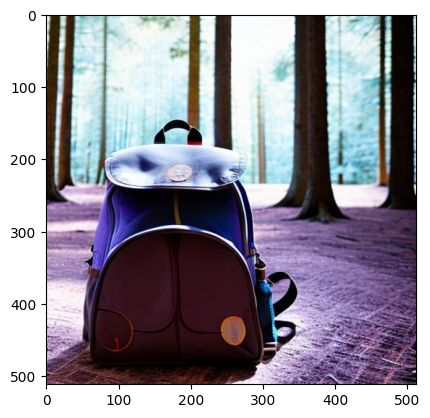

In [25]:
image = cv2.imread(IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [26]:
masks = mask_generator.generate(image)

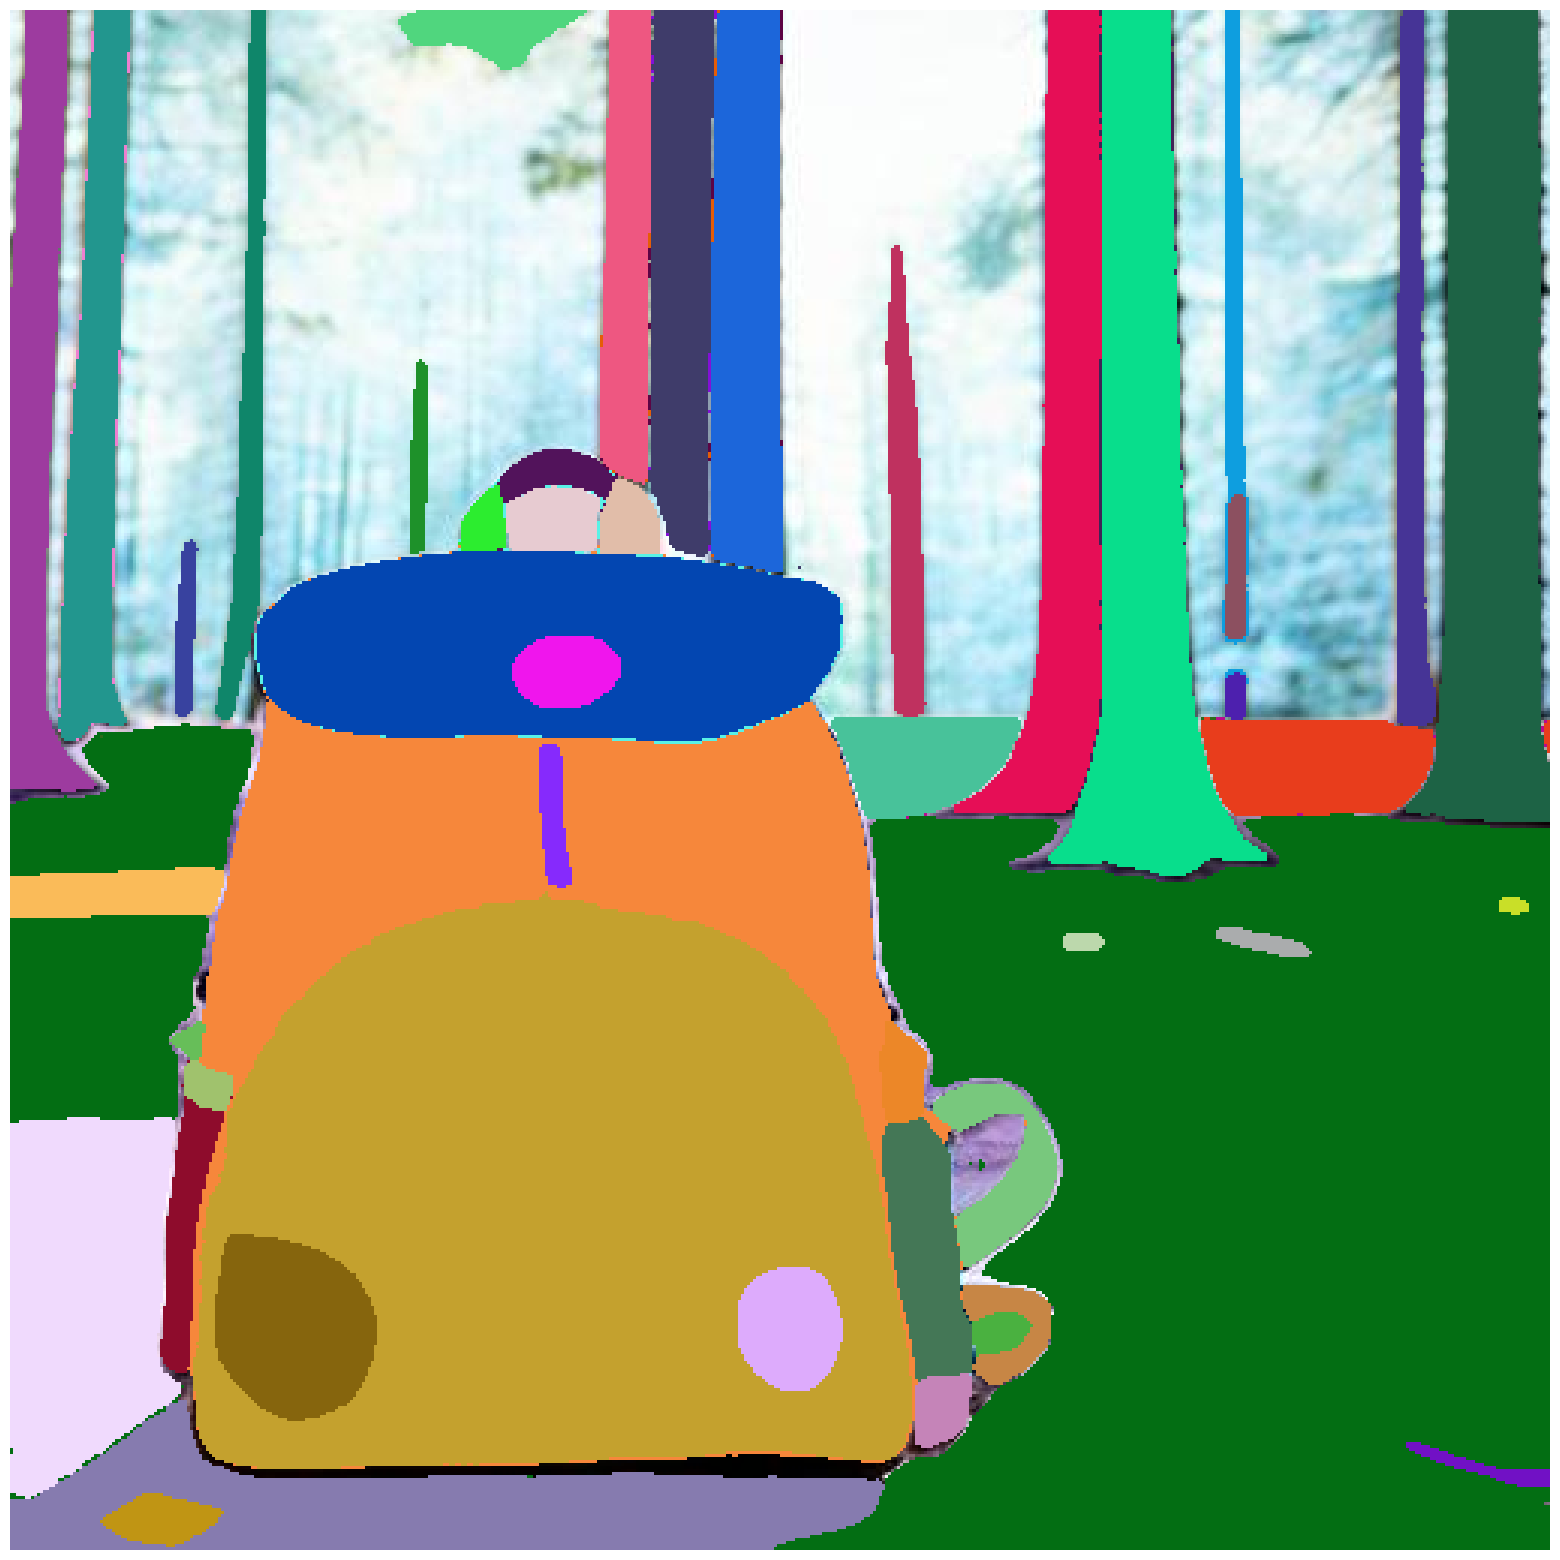

In [27]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [28]:
mask = masks[0]
def get_mask_score(mask):
    C = 50 #100
    if mask['area'] < C * C:
        return -1
    masked_image = mask['segmentation'][:, :, None] * image
    masked_pil_image = Image.fromarray(masked_image)
    return get_dino_score(ref_embeds, masked_pil_image)

In [29]:
best_mask_idx = -1
best_score = -100
for i in range(len(masks)):
    score = get_mask_score(masks[i])
    if score > best_score:
        best_score = score
        best_mask_idx = i

In [30]:
best_mask_idx

4

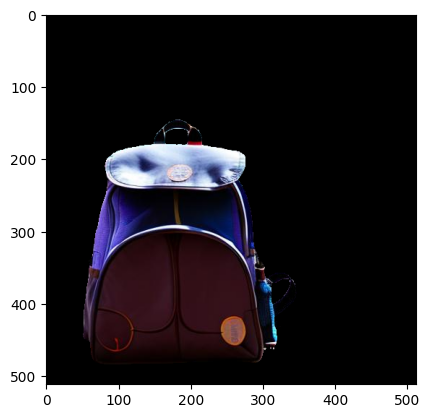

In [31]:
mask = masks[best_mask_idx]
masked_image = mask['segmentation'][:, :, None] * image
plt.imshow(masked_image)

### Inpainting part

In [32]:
from diffusers import StableDiffusionInpaintPipeline
inpipe = StableDiffusionInpaintPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting")
inpipe.to(device)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.27.0",
  "_name_or_path": "stabilityai/stable-diffusion-2-inpainting",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

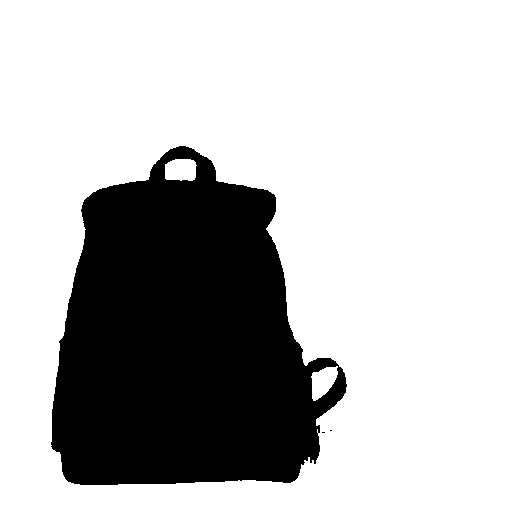

In [33]:
mask_pil = Image.fromarray(~ mask['segmentation'])
mask_pil

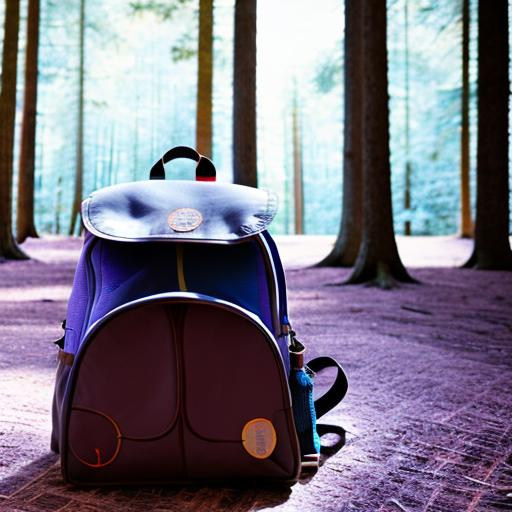

In [34]:
image_pil = Image.fromarray(image)
image_pil

  0%|          | 0/50 [00:00<?, ?it/s]

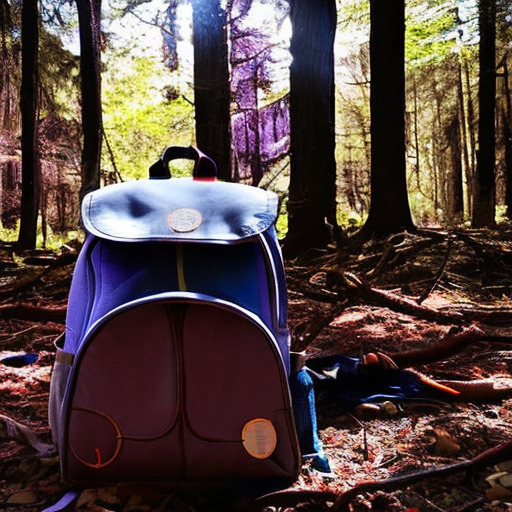

In [39]:
image = inpipe(prompt="a photo of a backpack on top of a purple rug in a forest", image=image_pil, mask_image=mask_pil).images[0]
image